## 1. Introduction
This HW represents a research on pratactical constructions in Russian newspaper language (because RNC is annoyingly stupid these days).

In [8]:
#import packages
import spacy
import scipy
from string import punctuation
import pymorphy2
import sqlite3
import pandas as pd
import re
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import random
random.seed = 23

In [10]:
nlp = spacy.load("ru_core_news_sm")

In [11]:
from pymorphy2 import MorphAnalyzer
morph = MorphAnalyzer()

In [12]:
def tokenize(s):
    words = ''
    p = list(punctuation)
    for i in range(len(s)):
        if s[i] in p:
            continue
        words = words + s[i]
    phrase = str(words)
    spltd = phrase.split()
    return spltd

## 2. Data and preprocessing

File *data_par.txt* contains aa collection of not annotated (raw) texts from the Taiga corpus (Fontanka subcorpus, 2003-2007).

In [13]:
with open('data_par.txt', encoding = 'utf-8') as f:
    text = f.read()

In [14]:
lines = text.splitlines() 

Let us do the preprocessing. Moreover, with the help of spacy package lets collect all the sentences that illustrate instances of parataxis.

In [15]:
with_par = []
for l in lines:
    line = ' '.join(tokenize(l))
    d = nlp(line)
    for token in d:
        dep = token.dep_
        if dep == "parataxis":
            with_par.append(line)

Next, I collect information on the heads in paratactical constructions (including morphological analysis) and their immediate and second-order dependants. 

In [16]:
paratax0 = {}
for wp in with_par:
    d = nlp(wp)
    for token in d:
        dep = token.dep_
        if dep == "parataxis":
            tok = token.text
            lemm = token.lemma_
            pos = token.pos_
            ana = morph.parse(tok)
            tag = ana[0].tag
            children = [child for child in token.children]
            for c in children:
                if c.is_ancestor:
                    grandchildren = list(c.children)
            paratax0[tok] = [lemm, pos, tag, children, grandchildren]

To proceed further, I calculate number of children and grandchildren in each construction.

In [18]:
num_children = []
num_grandchildren = []
for i in range(len(paratax0)):
    key = list(paratax0.keys())[i]
    values = list(paratax0[key])
    chil = len(values[3])
    num_children.append(chil)
    granch = len(values[4])
    num_grandchildren.append(granch)

## 3. Database creation

In [19]:
conn = sqlite3.connect('parataxis.db')

In [20]:
c = conn.cursor()

The first table in my database contains information on heads: head token, head lemma, part of speech of the head, a detailed morphological analysis, number it's syntactic children and grandchildren.

In [21]:
c.execute("CREATE TABLE IF NOT EXISTS parataxis_1(id integer PRIMARY KEY, head text, lemma text, POS text, morp_analys txt, children integer, grand_children integer)")

In [22]:
for p in range(len(paratax0)):
    x = p
    y = list(paratax0.keys())[p]
    z = list(paratax0[y])[0]
    n = list(paratax0[y])[1]
    m = str(list(paratax0 [y])[2])
    j = num_children[p]
    q = num_grandchildren[p]
    c.execute('INSERT INTO parataxis_1 VALUES (?, ?, ?, ?, ?, ?, ?)', (x, y, z, n, m, j, q))
conn.commit()

Let us have an overview of the table.

In [ ]:
for row in c.execute('SELECT * FROM parataxis_1'):
    print(row)

Second table of the database represents information on children. Mainly -- on the tokens.

In [25]:
c.execute("CREATE TABLE IF NOT EXISTS childs(id_child integer, num_child integer, child text)")

In [27]:
for p in range(len(paratax0)):
    x = p
    y = list(paratax0.keys())[p]
    z = list(paratax0[y])[3]
    for i in range(len(z)):
            n = str(z[i])
            order = i+1
            c.execute('INSERT INTO childs VALUES (?, ?, ?)', (x, order, n))

In [ ]:
for row in c.execute('SELECT * FROM childs'):
    print(row)

Third table overviews grandchildren.

In [30]:
c.execute("CREATE TABLE IF NOT EXISTS grandchilds(id_grandchild integer, num_grandchild integer, grandchild text)")

In [31]:
for p in range(len(paratax0)):
    x = p
    y = list(paratax0.keys())[p]
    z = list(paratax0[y])[4]
    for i in range(len(z)):
            n = str(z[i])
            order = i+1
            c.execute('INSERT INTO grandchilds VALUES (?, ?, ?)', (x, order, n))

In [ ]:
for row in c.execute('SELECT * FROM grandchilds'):
    print(row)

## 4. Data exploration

In this section I will explore my data and give it a statistical descriptive analysis with the help of pandas.

In [21]:
parataxis_query = """SELECT * 
FROM parataxis_1"""

In [22]:
df_paratax = pd.read_sql_query(parataxis_query, con=conn)
df_paratax

,id,head,lemma,POS,morp_analys,children,grand_children
0,0,передает,передавать,VERB,"VERB,impf,tran sing,3per,pres,indc",1,0
1,1,сообщает,сообщать,VERB,"VERB,impf,tran sing,3per,pres,indc",4,2
2,2,сказал,сказать,VERB,"VERB,perf,tran masc,sing,past,indc",2,1
3,3,словам,слово,NOUN,"NOUN,inan,neut plur,datv",2,1
4,4,стало,стать,VERB,"VERB,perf,intr neut,sing,past,indc",2,1
...,...,...,...,...,...,...,...
385,385,возможны,возможный,ADJ,"ADJS,Qual plur",2,0
386,386,имевших,иметь,VERB,"PRTF,impf,tran,past,actv plur,gent",4,2
387,387,совершил,совершить,VERB,"VERB,perf,tran masc,sing,past,indc",5,2
388,388,занял,занять,VERB,"VERB,perf,tran masc,sing,past,indc",3,1


Let us add another column in the given dataset. This column gives information on the number of words in a pratactical construction.

In [23]:
df_paratax["number_words"] = df_paratax["children"] +  df_paratax["grand_children"] +1
df_paratax

,id,head,lemma,POS,morp_analys,children,grand_children,number_words
0,0,передает,передавать,VERB,"VERB,impf,tran sing,3per,pres,indc",1,0,2
1,1,сообщает,сообщать,VERB,"VERB,impf,tran sing,3per,pres,indc",4,2,7
2,2,сказал,сказать,VERB,"VERB,perf,tran masc,sing,past,indc",2,1,4
3,3,словам,слово,NOUN,"NOUN,inan,neut plur,datv",2,1,4
4,4,стало,стать,VERB,"VERB,perf,intr neut,sing,past,indc",2,1,4
...,...,...,...,...,...,...,...,...
385,385,возможны,возможный,ADJ,"ADJS,Qual plur",2,0,3
386,386,имевших,иметь,VERB,"PRTF,impf,tran,past,actv plur,gent",4,2,7
387,387,совершил,совершить,VERB,"VERB,perf,tran masc,sing,past,indc",5,2,8
388,388,занял,занять,VERB,"VERB,perf,tran masc,sing,past,indc",3,1,5


As we can suggest from the data above, there are a lot of examples of paratactical constructions with verbal heads. Let us check what time dimension is more often used in paratexis -- present or past. 

In [24]:
def infl(text):
    if re.search('pres', text):
        tense = "present"
    else:
        if re.search('past', text):
            tense ="past"
        else:
            tense = "NA"
    return tense

In [25]:
df_paratax["morp_analys"].apply(infl).value_counts()

past       153
NA         148
present     89
Name: morp_analys, dtype: int64

As can be seen from the table above, past tense is a more common tense form in parataxis. This is logical, since parataxis often gives source of information (smth that was said or written before).

Let us find the longest paratactical construction in words.

In [26]:
df_paratax.sort_values(by="number_words", ascending=False)

,id,head,lemma,POS,morp_analys,children,grand_children,number_words
160,160,ловил,ловить,VERB,"VERB,impf,tran masc,sing,past,indc",12,4,17
292,292,сняли,снять,VERB,"VERB,perf,tran plur,past,indc",5,5,11
351,351,ожидал,ожидать,VERB,"VERB,impf,tran masc,sing,past,indc",4,6,11
45,45,догадаетесь,догадаетесь,VERB,"VERB,perf,intr plur,2per,futr,indc",4,6,11
54,54,дают,давать,VERB,"VERB,impf,tran plur,3per,pres,indc",7,3,11
...,...,...,...,...,...,...,...,...
100,100,3,3,NUM,"NUMB,intg",0,0,1
272,272,закладываются,закладываться,VERB,"VERB,impf,intr plur,3per,pres,indc",0,0,1
285,285,25,25,NUM,"NUMB,intg",0,0,1
307,307,1621,1621,NUM,"NUMB,intg",0,0,1


The answer is 17.

Let us do the same but this time only for constructions that have nouns as their heads.

In [27]:
df_paratax[df_paratax["POS"] == "NOUN"].sort_values(by="number_words", ascending=False)

,id,head,lemma,POS,morp_analys,children,grand_children,number_words
214,214,парк,парк,NOUN,"NOUN,inan,masc sing,nomn",5,5,11
233,233,Парком,парк,NOUN,"NOUN,inan,masc sing,ablt",5,3,9
151,151,окраинах,окраина,NOUN,"NOUN,inan,femn plur,loct",4,3,8
336,336,рейтинг,рейтинг,NOUN,"NOUN,inan,masc sing,accs",4,3,8
91,91,кризис,кризис,NOUN,"NOUN,inan,masc sing,nomn",3,3,7
...,...,...,...,...,...,...,...,...
204,204,стокгольме,стокгольм,NOUN,"NOUN,inan,masc,Geox sing,loct",2,0,3
271,271,бросание,бросание,NOUN,"NOUN,inan,neut sing,nomn",1,0,2
44,44,дело,дело,NOUN,"NOUN,inan,neut sing,nomn",1,0,2
326,326,сведениям,сведение,NOUN,"NOUN,inan,neut plur,datv",1,0,2


The answer is 11.

## 5. Visualizations

It makes sense to explore the frequences of different parts of speech in head position in parataxis. This can be done with the help of pie-chart.

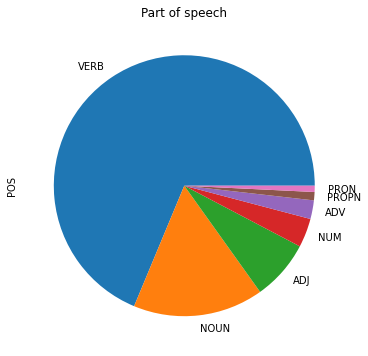

In [73]:
plt.figure(figsize=(6, 6))
df_paratax['POS'].value_counts().plot(kind='pie');
plt.title('Part of speech');

Verbs constitute the majority of paratactical heads.

Now let us visualize distribution of the amount of children.

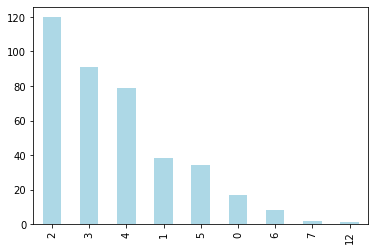

In [71]:
df_paratax['children'].value_counts().plot.bar(color='lightblue')

As can be seen in the picture, most of the examples of parataxis had 2 entities on the second syntactic level.

For the grandchildren the picture is different.

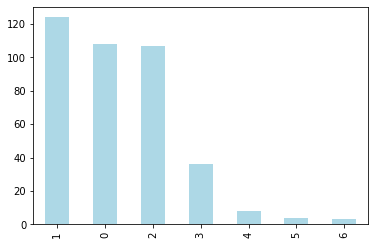

In [70]:
df_paratax['grand_children'].value_counts().plot.bar(color='lightblue')

In most of the constructions there was only one entity on the third syntactic level. This suggests that paratactical constructions usually are not syntactically deep and rich.

Let us find how the number of children was different among the heads with different POS fearutes.

In [29]:
df_paratax2 = df_paratax[["POS", 'children']] 
df_paratax3 = df_paratax2.groupby("POS", as_index=False).agg({"children": "mean"})

In [103]:
df_paratax3

,POS,children
0,ADJ,2.137931
1,ADV,1.777778
2,NOUN,2.873016
3,NUM,0.857143
4,PRON,2.333333
5,PROPN,3.000000
6,VERB,3.063433


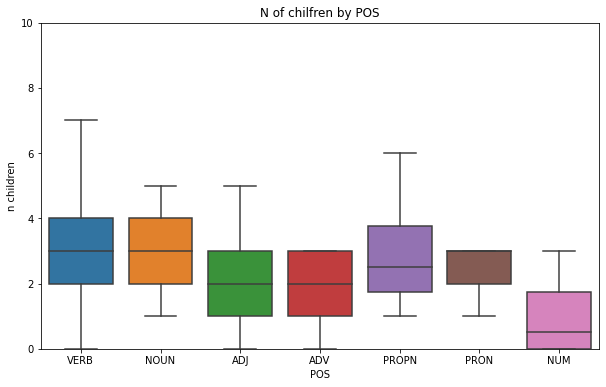

In [107]:
plt.figure(figsize=(10, 6))
sns.boxplot(x="POS", y="children", data=df_paratax2)
plt.ylim((0, 10))
plt.title('N of chilfren by POS')
plt.ylabel('n children')
plt.xlabel('POS');

## 6. Statistics

Let us check if the difference observed between the nubmer of syntactic children held by verbs and nouns is statistically significant with the help of the t-test.

In [35]:
x = list(df_paratax2[df_paratax2["POS"] == "VERB"]["children"])
y = list(df_paratax2[df_paratax2["POS"] == "NOUN"]["children"])

In [34]:
scipy.stats.ttest_ind(y, x)

Ttest_indResult(statistic=-0.9947706744106909, pvalue=0.3205788751671245)

As can be concluded by the obtained p-value, there is no singificant difference between the number of immediate dependents of verbal and nominal heads in paratactical constructions in Russian newspaper text.

## PS

For my final project I would like to conduct a similar study but on a more representative material (RNC). The main objective of this study would be to identify classes of paratactical constructions in Russian.